In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-player-segmentation/annotations/instances_default.json
/kaggle/input/football-player-segmentation/images/208.jpg


In [1]:
!pip install -q imantics
!pip install -q segmentation_models_pytorch

In [26]:
import os, sys
import random
import json

from tqdm import tqdm
import imantics
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import albumentations as A

In [5]:
N_IMAGES = 512
TRAIN_IMAGE_SIZE = 512
INPUT_IMAGE_SIZE = (1920, 1080)

In [6]:
with open("../input/football-player-segmentation/annotations/instances_default.json") as f:
    annotations = json.load(f)

In [7]:
map_id_filename = {}
for index in range(len(annotations["images"])):
    map_id_filename[annotations["images"][index]["id"]] = annotations["images"][index]["file_name"]

In [8]:
images = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE, 3), dtype=np.uint8)

for image_id, image_filename in map_id_filename.items():
    cur_image = cv2.imread(f"../input/football-player-segmentation/images/{image_filename}")
    cur_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2RGB)
    cur_image = cv2.resize(cur_image, (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE))

    images[image_id - 1] = cur_image

In [9]:
masks = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE), dtype=bool)

for index in range(len(annotations["annotations"])):
    image_id = annotations["annotations"][index]["image_id"]
    segmentation = annotations["annotations"][index]["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*INPUT_IMAGE_SIZE).array
    cur_mask = cv2.resize(cur_mask.astype(float), (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE)) >= 0.5

    masks[image_id - 1] = masks[image_id - 1] | cur_mask

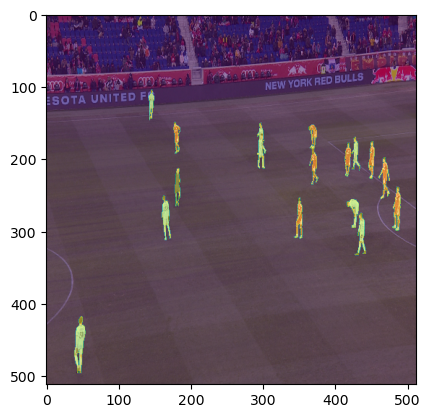

In [12]:
plt.imshow(images[0])
plt.imshow(masks[0], alpha=0.5)

In [13]:
class CFG:
    seed = 42
    train_size = 0.8
    batch_size = 4
    lr = 0.001
    n_epochs = 5
    device = "cuda"

In [14]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

In [15]:
indexes = list(range(N_IMAGES))
train_indexes = indexes[: int(N_IMAGES * CFG.train_size)]
valid_indexes = indexes[int(N_IMAGES * CFG.train_size) :]

In [18]:
len(train_indexes), len(valid_indexes)

(409, 103)

In [19]:
def get_transforms():
    return A.Compose(
        [
            A.HueSaturationValue( # Change colors
                p=1.0, 
                hue_shift_limit=(-20, 20), 
                sat_shift_limit=(-30, 30), 
                val_shift_limit=(-20, 20),
            ),
            A.HorizontalFlip(p=0.5),
        ], 
        p=1.0
    )

In [20]:
class CustomDataset(Dataset):
    def __init__(self, indexes, transform=None, preprocess=None):
        self.indexes = indexes
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, index):
        _index = self.indexes[index]

        image = images[_index]
        mask = masks[_index]
        
        if self.transform:
            data = {"image": image, "mask": mask}
            augmented = self.transform(**data)
            image, mask = augmented["image"], augmented["mask"]
        
        if self.preprocess:
            image = self.preprocess(image)
        
        image = torch.tensor(image, dtype=torch.float)
        mask = torch.tensor(mask, dtype=torch.float)

        image = image.permute(2, 0, 1)
        mask = mask.unsqueeze(0)

        return {"image": image, "mask": mask}

In [21]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

preprocess_input = get_preprocessing_fn("resnet50", pretrained="imagenet")

train_dataset = CustomDataset(
    train_indexes, transform=get_transforms(), preprocess=preprocess_input
)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

valid_dataset = CustomDataset(valid_indexes, preprocess=preprocess_input)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 272MB/s]


In [22]:
model.to(CFG.device)

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=CFG.lr)

In [23]:
def iou(outputs, labels) -> float:
    intersection = np.sum(np.logical_and(outputs, labels), axis=(1, 2, 3))
    union = np.sum(np.logical_or(outputs, labels), axis=(1, 2, 3))
    iou = intersection / union
    return np.mean(iou)

In [29]:
train_loss_history = []
val_loss_history = []
train_iou_history = []
val_iou_history = []

for epoch in range(CFG.n_epochs):
    train_loss = 0
    train_iou = 0
    
    model.train()
    train_dataloader = tqdm(train_dataloader, file=sys.stdout, colour='red')
    for i, batch in enumerate(train_dataloader):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
        train_iou += _iou
        
        train_dataloader.desc = "Epoch [{}/{}], Train Loss: {:.4f}, Train IOU: {:.4f}".format(
            epoch + 1, CFG.n_epochs, train_loss/(i+1), train_iou/(i+1))

    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou)

    val_loss = 0
    val_iou = 0
    model.eval()
    valid_dataloader = tqdm(valid_dataloader, file=sys.stdout, colour='red')
    with torch.no_grad():
        for i, batch in enumerate(valid_dataloader):
            inputs = batch["image"].to(CFG.device)
            labels = batch["mask"].to(CFG.device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
            val_iou += _iou
            
            valid_dataloader.desc = "Epoch [{}/{}], Val Loss: {:.4f}, Val IOU: {:.4f}".format(
                    epoch + 1, CFG.n_epochs, val_loss/(i+1), val_iou/(i+1)
        )
            
    

    val_loss /= len(valid_dataloader)
    val_iou /= len(valid_dataloader)
    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)

Epoch [1/5], Train Loss: 0.0203, Train IOU: 0.8067: 100%|██████████| 103/103 [00:54<00:00,  1.87it/s]
Epoch [1/5], Val Loss: 0.0152, Val IOU: 0.8088: 100%|██████████| 26/26 [00:02<00:00, 10.23it/s]
Epoch [2/5], Train Loss: 0.0131, Train IOU: 0.8329: 100%|██████████| 103/103 [00:55<00:00,  1.87it/s]
Epoch [2/5], Val Loss: 0.0100, Val IOU: 0.8594: 100%|██████████| 26/26 [00:02<00:00, 10.38it/s]
Epoch [3/5], Train Loss: 0.0104, Train IOU: 0.8445: 100%|██████████| 103/103 [00:54<00:00,  1.88it/s]
Epoch [3/5], Val Loss: 0.0091, Val IOU: 0.8502: 100%|██████████| 26/26 [00:02<00:00,  9.42it/s]
Epoch [4/5], Train Loss: 0.0089, Train IOU: 0.8544: 100%|██████████| 103/103 [00:54<00:00,  1.89it/s]
Epoch [4/5], Val Loss: 0.0076, Val IOU: 0.8694: 100%|██████████| 26/26 [00:02<00:00, 10.21it/s]
Epoch [5/5], Train Loss: 0.0080, Train IOU: 0.8627: 100%|██████████| 103/103 [00:54<00:00,  1.88it/s]
Epoch [5/5], Val Loss: 0.0067, Val IOU: 0.8783: 100%|██████████| 26/26 [00:02<00:00,  9.96it/s]


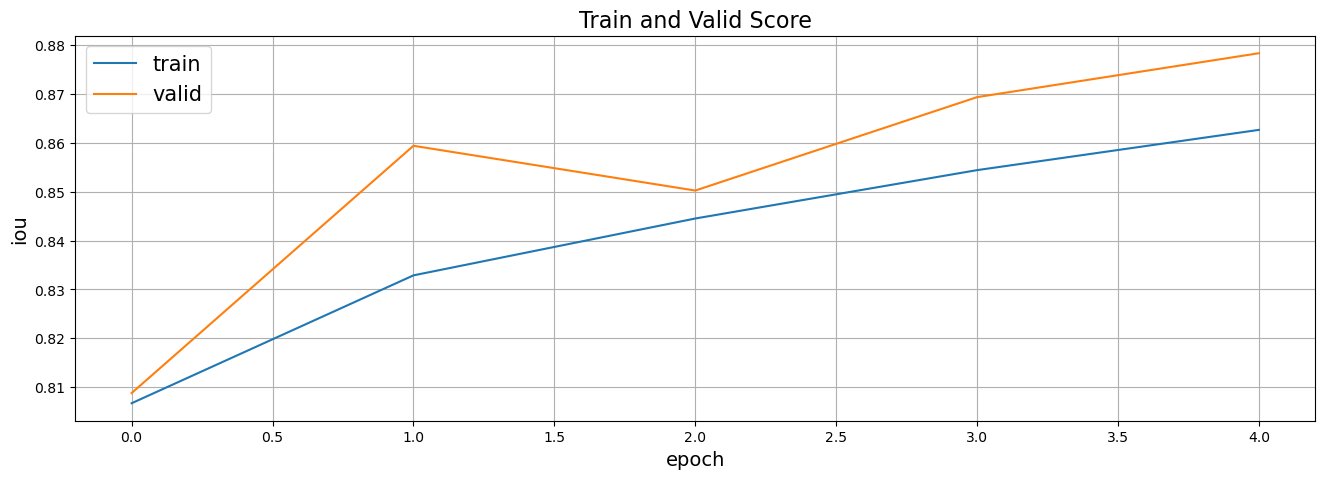

In [30]:
plt.figure(figsize=(16, 5))
plt.plot(range(CFG.n_epochs), train_iou_history, label="train")
plt.plot(range(CFG.n_epochs), val_iou_history, label="valid")

plt.title("Train and Valid Score", fontsize=16)
plt.legend(fontsize=15)
plt.ylabel("iou", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.grid()
plt.show()

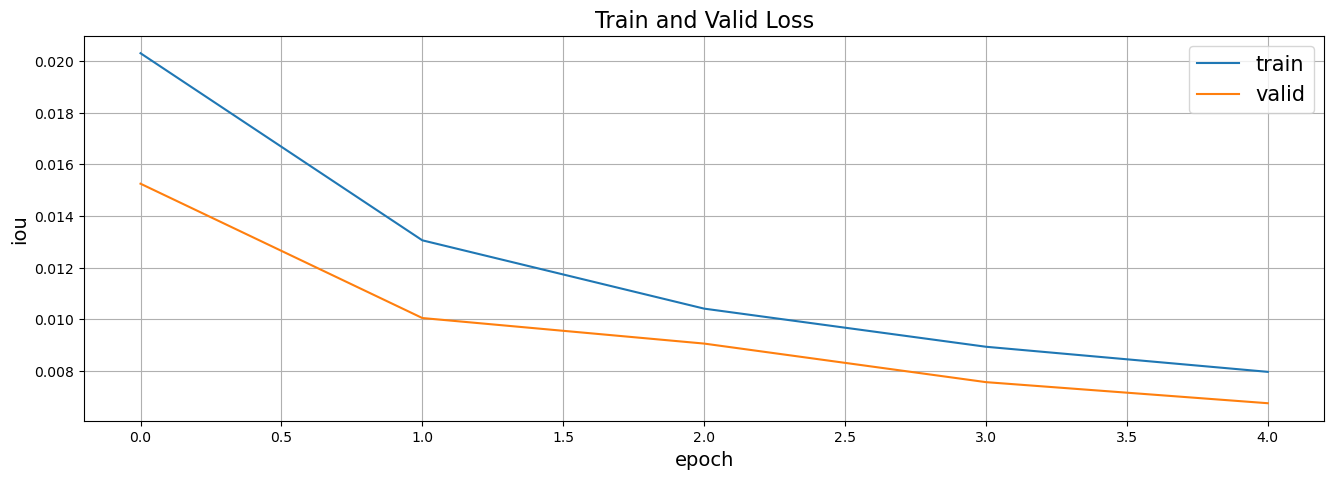

In [31]:
plt.figure(figsize=(16, 5))
plt.plot(range(CFG.n_epochs), train_loss_history, label="train")
plt.plot(range(CFG.n_epochs), val_loss_history, label="valid")

plt.title("Train and Valid Loss", fontsize=16)
plt.legend(fontsize=15)
plt.ylabel("iou", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.grid()
plt.show()

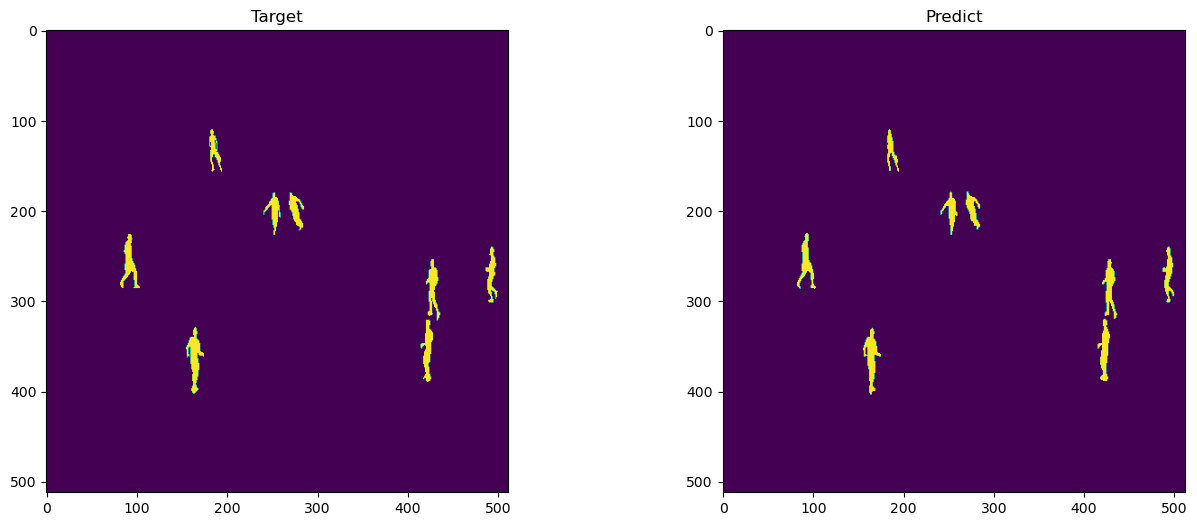

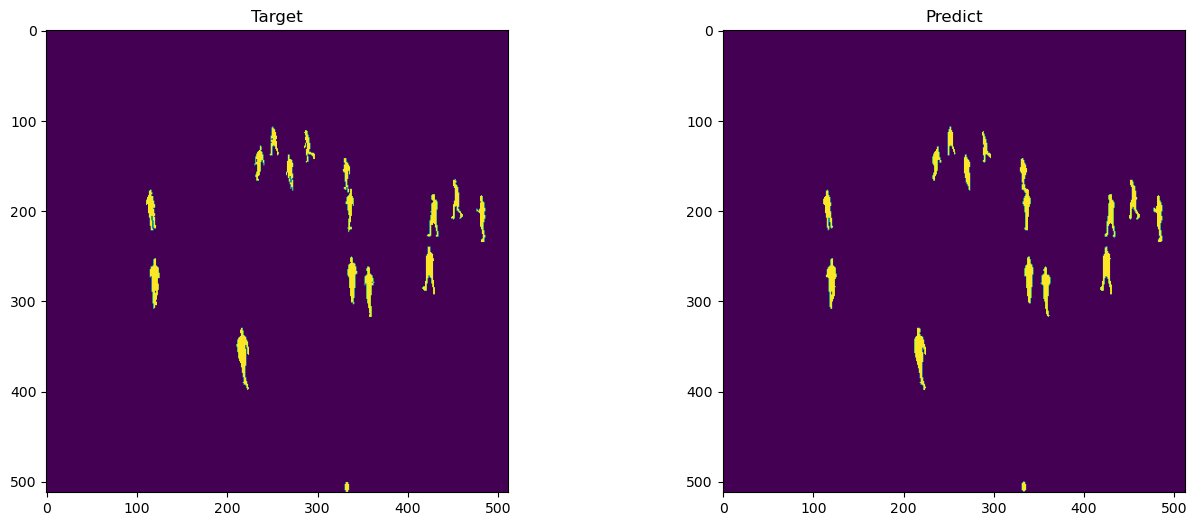

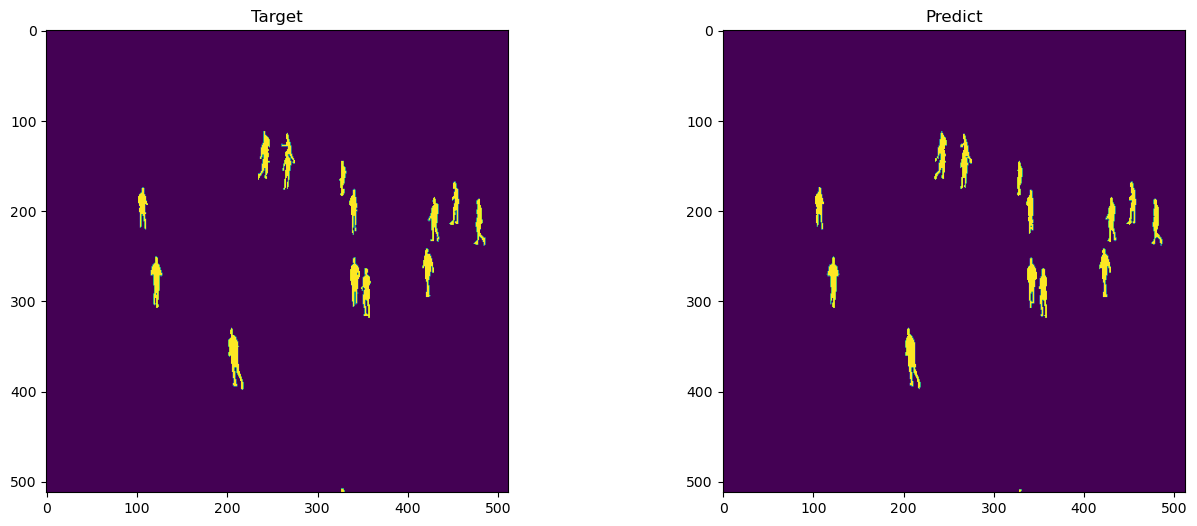

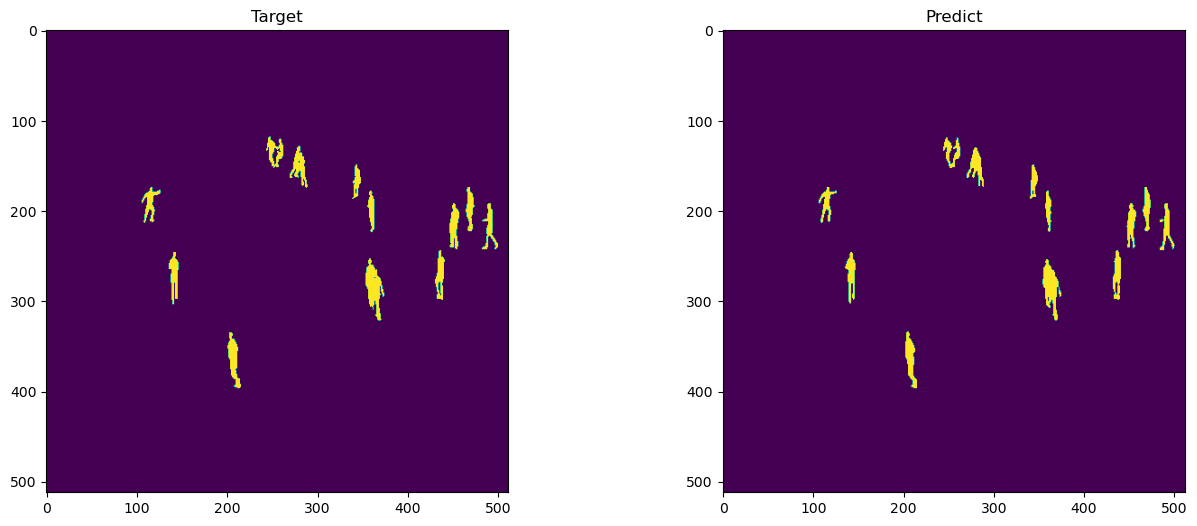

In [32]:
with torch.no_grad():
    for i, batch in enumerate(valid_dataloader):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        outputs = model(inputs)

        np_labels = labels.detach().cpu().numpy()
        np_outputs = outputs.detach().cpu().numpy()

        for i in range(len(np_labels)):
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(np_labels[i][0])
            plt.title("Target")
            plt.subplot(1, 2, 2)
            plt.imshow(np_outputs[i][0] >= 0)
            plt.title("Predict")
            plt.show()
        
        break